# Import the MNIST Dataset

In [134]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
import seaborn as sns

# A crucial step in ensuring reproducibility!
# np.random.seed(0) sets the seed for the NumPy random number generator to a fixed value (in this case, 0). 
# This ensures that the subsequent random number generations will be deterministic and reproducible.
# When you set a seed for the random number generator, it means that the sequence of random numbers generated by the algorithm will always start with the same value. 
# This is useful when:
#    - You want to reproduce results: By setting the seed, you can guarantee that your code will produce the same output every time, which is essential for reproducing 
#      experimental results or sharing code with others.
#    - You need consistent testing: Randomness can be difficult to test, but by fixing the seed, you can create a controlled environment for testing and validation.
# In this specific case, setting the seed might not have a direct impact on your MNIST dataset analysis, but it's still a good practice to ensure reproducibility 
# and consistency in your code.
np.random.seed(0)

# Demo parameters 
_hidden_layer_number=4      # Number of layers in the Neural Network (min=2)
_hidden_layer_depth=512     # Depth of each layer = number of Neurons


# Split the Dataset to prepare for training and testing phases

In [135]:
# Import the MNIST Dataset directly from keras includzed datasets
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [136]:
# Print the shape of the training and tests sets
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


# Visualize some Sample Examples from the MNIST Dataset

Display images of all possible modalities in the MNIST dataset:

Random image at index 2732 :
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - O O - - - - - 
- - - - - - - - O - - - - - - - - - - - - O O - - - - - 
- - - - - - - O O O - - - - - - - - - - O O O - - - - - 
- - - - - - - O O O - - - - - - - - - - O O O - - - - - 
- - - - - - - O O O - - - - - - - - - O O O O - - - - - 
- - - - - - O O O O - - - - - - - - - O O O O - - - - - 
- - - - - - O O O O - - - - - - - - - O O O - - - - - - 
- - - - - - O O O O - - - - - - - - - O O O - - - - - - 
- - - - - - O O O - - - - - - - - - - O O O - - - - - - 
- - - - - - O O O - - - - - - - - - - O O O O - - - - - 
- - - - - O O O O - - - - - - - O O O O O O - - - - - - 
- - - - - O O O O O O O O O O O O O O O O O - - - -

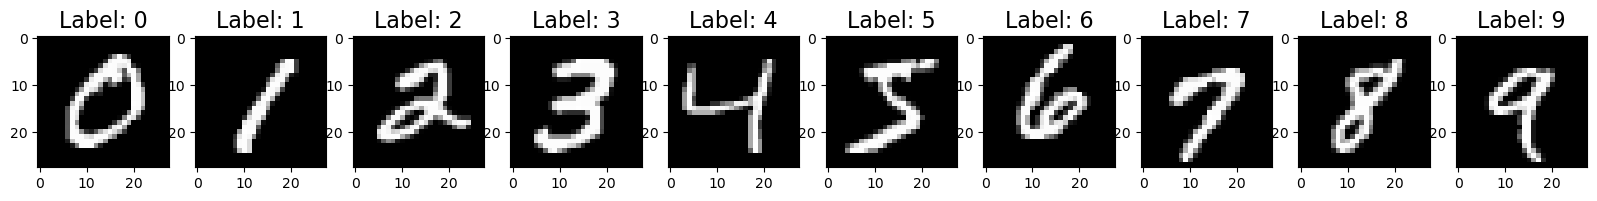

In [137]:
# Define the number of classes (e.g., digits 0-9)
num_classes = 10

# Create a figure with subplots for each class
f, ax = plt.subplots(1, num_classes, figsize=(20,20))

print('Display images of all possible modalities in the MNIST dataset:\n')

# Loop on the x_train dataset to display all possible modalities in the dataset (test on y_test that we know is true)
for i in range(0, num_classes):
  # Get the first sample from the current class (assuming x_train and y_train are available)
  sample = x_train[y_train == i][0]

  # Display the sample as an image using grayscale colormap
  ax[i].imshow(sample, cmap='gray')

  # Set the title of the subplot with the label number
  ax[i].set_title("Label: {}".format(i), fontsize=16)

# Pick a random index and print the [28x28] matrix corresponding to the image at this index
# We will set 0 and 1 values only in the matrix to show the numbers with '1'
random_idx = np.random.choice(len(x_train))

# Print image matrix with real values
#print(x_train[random_idx])

# Print image matrix with values normalized to 0 ('-') or 1 ('x')
image = x_train[random_idx].reshape((28, 28))
print("Random image at index", random_idx, ":")
for row in image:
        for pixel in row:
            if pixel > 127:
                print("O", end=' ')
            else:
                print("-", end=' ')
        print()

# Assuming x_train is a NumPy array with shape (60000, 784)
#num_images = len(x_train)
#for i in range(num_images):
#    image = x_train[i].reshape((28, 28))
#    print("Image", i, ":\n")
#    print(image)


In [138]:
# In Keras, when working with categorical labels (i.e., discrete outcomes), you need to convert them into a categorical format. 
# This is because the default loss function and optimization algorithms assume that the outputs are real-valued (continuous).

# The to_categorical() function from Keras' utils module does just that: it converts  integer-encoded categorical labels into one-hot encoded arrays.
# Here's what happens:
#    For each sample in y_train and y_test, you get a vector of length num_classes, where:
#       The index corresponding to the true class label is set to 1 (i.e., True or 1).
#       All other indices are set to 0 (i.e., False or 0).
# This one-hot encoded representation allows you to use categorical cross-entropy loss functions, such as categorical_crossentropy, which is commonly used for multi-class classification problems.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [139]:
# Loop through each sample in the training data and print its label again (after conversion)
for i in range(10):
  print(y_train[i])

# Print shape of the X training set
print(x_train.shape)

# Pick a random index and print the [28x28] matrix corresponding to the image at this index
random_idx = np.random.choice(len(x_train))
#print(x_train[random_idx])

#sample_img = x_train[random_idx].reshape(28,28)
#print(sample_img)

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(60000, 28, 28)


# Prepare Data for the training phase

In [140]:
# Normalize the pixel values of the training images by dividing each value by 255.0

# This code is normalizing the pixel values of the training and test images to be between 0 and 1, which is a common practice in deep learning models.
# In this case, it's likely that the original pixel values were between 0 and 255 (i.e., 8-bit grayscale), so dividing each value by 255.0 brings 
# them down to the range [0, 1]. This normalization helps to:
#   Reduce the effect of large pixel values on the model's training and testing
#   Make the model more robust to small variations in brightness or contrast
#   Improve the convergence and accuracy of the model
# Note that this is a simple form of data normalization. 
# In some cases, you may need to use more sophisticated techniques, such as mean subtraction or standardization, depending on the specific characteristics 
# of your dataset.
x_train = x_train / 255.0
x_test = x_test / 255.0

In [141]:
# Reshape the test images from (height, width, channels) to (samples, features)

# The -1 in the reshape method is a special value that tells NumPy to automatically calculate the size based on the other dimensions. 
# In this case, it means that the first dimension (the number of samples) will remain unchanged, and the second dimension (the number of features) 
# will be calculated as the product of the height, width, and channels.

# Before reshaping, x_train likely had a shape like ( Samples, Height, Width, Channels ), where each image is represented by a 4D array with three 
# dimensions for spatial information (height, width, and channels).

# After reshaping, x_train will have a shape like (Samples, Features), where the number of features is equal to the product of height, width, and channels. 
# This is often referred to as a "flat" or "vectorized" representation, which is suitable for inputting into neural networks.

# By printing the shape of x_train using print(x_train.shape), you can verify that the reshaping was successful and check the new shape of your data.

x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
print(x_train.shape)

(60000, 784)


# Create the Model : a Fully Fast Forward Connected Neural Network (CNN)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 512)               401920    
                                                                 
 dense_28 (Dense)            (None, 512)               262656    
                                                                 
 dense_29 (Dense)            (None, 512)               262656    
                                                                 
 dense_30 (Dense)            (None, 512)               262656    
                                                                 
 dense_31 (Dense)            (None, 512)               262656    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_32 (Dense)            (None, 10)               

Total params: 1,457,674
Trainable params: 1,457,674
Non-trainable params: 0
_________________________________________________________________


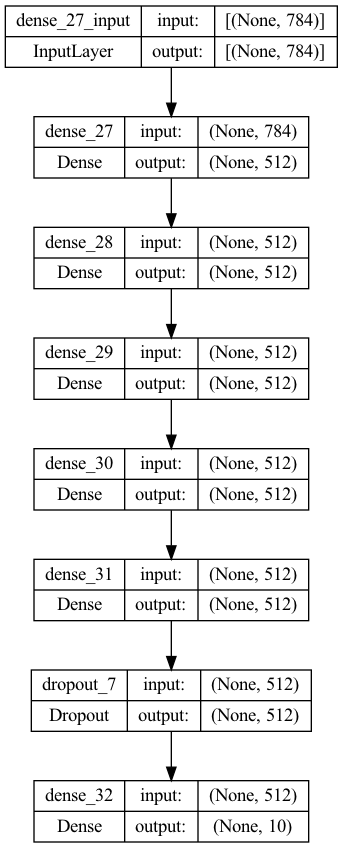

In [142]:
# Create a neural network model using the Sequential API
model = Sequential()

# INPUT LAYER

# Add a dense (fully-connected) layer with default of '_hidden_layer_depth'units, input shape (784,), and ReLU activation
# This layer will process the input data and produce an output
model.add(Dense(units=_hidden_layer_depth, input_shape=(784,), activation='relu'))

for _ in range(_hidden_layer_number):
    # Add another dense layer with a defaukt of 128 units and ReLU activation
    # This layer will process the output from the previous layer and produce another output
    model.add(Dense(units=_hidden_layer_depth, activation='relu'))

# Add a dropout layer with a drop rate of 0.25 (25%)
# Dropout randomly sets 25% of the neurons to zero during training to prevent overfitting
model.add(Dropout(0.25))

# Add a final dense layer with 10 units and softmax activation
# This layer will produce a probability distribution over the 10 classes
model.add(Dense(units=10, activation='softmax'))

# Compile the model with categorical cross-entropy loss function, Adam optimizer, and accuracy metric
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print a summary of the model architecture using the `summary()` method
model.summary()

#                   +---------------+
#                   |  Input Layer  |
#                   +---------------+
#                               |
#                               | (784,)
#                               v
# +-----------------------+       +-----------------------+
# |      Dense Layer      |       |      Dense Layer      |
# |      (128, ReLU)      |       |      (128, ReLU)      |
# +-----------------------+       +-----------------------+
#                               |
#                               | (0.25 dropout)
#                               v
# +-----------------------+       +-----------------------+
# |      Dropout Layer    |       |        None           |
# +-----------------------+       +-----------------------+
#                               |
#                               v
# +-----------------------+       +-----------------------+
# |     Final Dense Layer |       |  Softmax Activation   |
# |      (10, Softmax)    |       |                       |
# +-----------------------+       +-----------------------+

# Note that this schema is a simplified representation of the model architecture. 
# The actual connections between layers may be more complex and involve additional operations such as convolutional layers, pooling layers, etc.

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


# Train

In [143]:
# Define the batch size for training (number of samples to process in parallel)
batch_size = 512

# Define the number of epochs for training (iterations over the entire dataset)
epochs=10

# Train the model using the `fit` method
# x_train: input data, y_train: target labels
model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/10
118/118 [==============================] - 3s 25ms/step - loss: 0.3519 - accuracy: 0.8936
Epoch 2/10
118/118 [==============================] - 3s 23ms/step - loss: 0.1051 - accuracy: 0.9678
Epoch 3/10
118/118 [==============================] - 3s 23ms/step - loss: 0.0634 - accuracy: 0.9799
Epoch 4/10
118/118 [==============================] - 3s 22ms/step - loss: 0.0442 - accuracy: 0.9856
Epoch 5/10
118/118 [==============================] - 3s 23ms/step - loss: 0.0355 - accuracy: 0.9888
Epoch 6/10
118/118 [==============================] - 3s 22ms/step - loss: 0.0295 - accuracy: 0.9907
Epoch 7/10
118/118 [==============================] - 3s 24ms/step - loss: 0.0229 - accuracy: 0.9927
Epoch 8/10
118/118 [==============================] - 3s 22ms/step - loss: 0.0211 - accuracy: 0.9935
Epoch 9/10
118/118 [==============================] - 3s 22ms/step - loss: 0.0198 - accuracy: 0.9936
Epoch 10/10
118/118 [==============================] - 3s 24ms/step - loss: 0.0157 - accura

# Evaluate

In [144]:
# Evaluate the model on the test data using the `evaluate` method
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Loss: {}, Test Accuracy: {}".format(test_loss, test_acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.0888 - accuracy: 0.9790
Test Loss: 0.08878044784069061, Test Accuracy: 0.9789999723434448


In [145]:
# Use the model to make predictions on the test data
y_pred = model.predict(x_test)

# Convert the predicted probabilities into class labels using `argmax`
y_pred_classes = np.argmax(y_pred, axis=1)
print(y_pred)
print(y_pred_classes)

# Here's what each part does:
#    model.predict(x_test) : This line uses the trained model to make predictions on the test data. 
#    The output is a NumPy array containing the predicted probability distribution for each sample in the test data.
#
#    y_pred_classes = np.argmax(y_pred, axis=1) : This line converts the predicted probabilities into class labels by taking the index of 
#    the maximum value along the specified axis (in this case, axis 1). The output is a NumPy array containing the predicted class labels for each sample in the test data.
#
#    print(y_pred) : This line prints out the predicted probability distributions for each sample in the test data. 
#    Each row represents a single prediction, and the columns represent the different classes (or outcomes) that the model can predict.
#
#    print(y_pred_classes) : This line prints out the predicted class labels for each sample in the test data.

313/313 [==============================] - 1s 2ms/step
[[3.7341455e-10 1.6333817e-07 4.2070102e-08 ... 9.9999249e-01
  1.2029813e-08 7.2024168e-06]
 [2.4204241e-09 5.9449427e-08 9.9999988e-01 ... 3.3606693e-09
  6.1082597e-09 1.1369501e-11]
 [4.5996441e-07 9.9998534e-01 4.1463613e-06 ... 1.3554518e-06
  4.7561211e-06 5.5261563e-07]
 ...
 [1.9171081e-13 1.5936027e-10 1.6876377e-11 ... 5.6945230e-11
  7.8154933e-10 1.1059007e-06]
 [1.9816336e-07 6.1163248e-09 1.0972291e-08 ... 1.6007704e-08
  7.3250212e-06 3.3776689e-07]
 [7.5921029e-08 7.6063433e-10 1.4668763e-10 ... 6.4708963e-12
  1.3323837e-08 1.5091113e-09]]
[7 2 1 ... 4 5 6]


Predicting Image at Index=2599, Size of x_sample=784


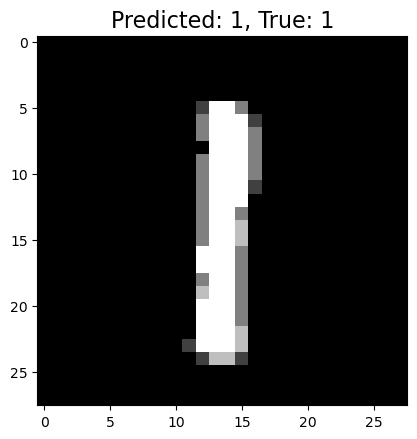

In [160]:
# Single PREDICTION Example on a random sample from the x_test dataset (not known during the training phase)

# Select a single random example from the test data for visualization by choosing a random index within the length of x_test
random_idx = np.random.choice(len(x_test))
#print(x_test[random_idx].shape)
#print(x_test[random_idx])

# Get the input data (features) at the chosen index
x_sample = x_test[random_idx]
print(f'Predicting Image at Index = {random_idx}, Size of x_sample = {len(x_sample)}')

# Now, extract the true and predicted class labels for this example

# And now, we have to onvert the one-hot encoded label to a class label (0-9)

# Let's explain more in depth this part:
#   np.argmax: This is a function from the NumPy library that finds the index of the maximum value along a specified axis.
#   y_test: This is a 2D NumPy array representing the true labels for the test data. Each row corresponds to a single sample, and each column represents a possible class label (in this case, digit classes 0-9).
#   axis=1: This specifies that we want to find the maximum value along the second axis (i.e., the rows). In other words, we're looking for the most likely class label for each individual sample.
# When you run this code, NumPy will iterate through each row of y_test, find the maximum value in that row, and return the corresponding index. 
# => This is equivalent to converting the one-hot encoded labels into a single class label (e.g., [0, 0, 1, 0] becomes 2, since 2 is the most likely class).
# The resulting array y_true will contain the true class labels for each sample in the test data.
y_true = np.argmax(y_test, axis=1)

# Get the true class label for this example
y_sample_true = y_true[random_idx]

# Get the predicted class label for this example
y_sample_pred_class = y_pred_classes[random_idx]

plt.title("Predicted: {}, True: {}".format(y_sample_pred_class, y_sample_true), fontsize=16)
plt.imshow(x_sample.reshape(28, 28), cmap='gray')

# Confusion Matrix

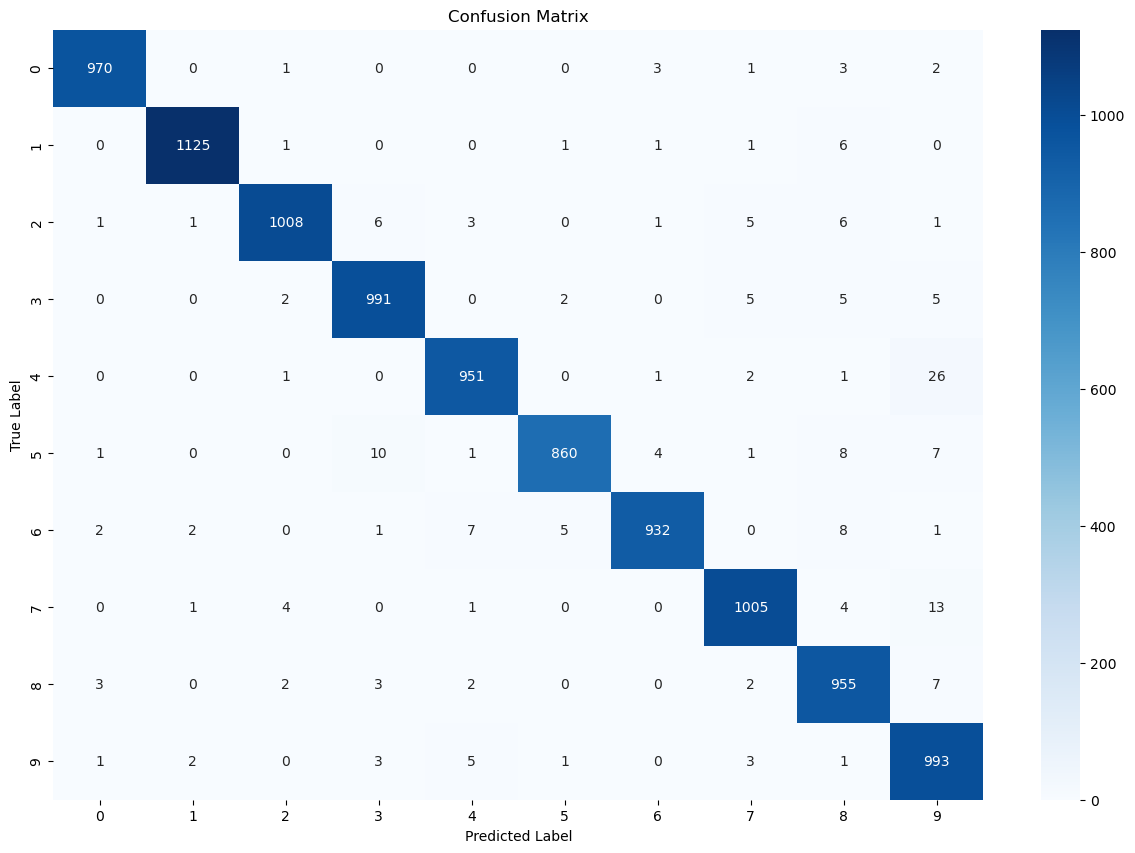

In [147]:
# This code calculates the confusion matrix : a table that summarizes the predictions made by a classification model, using the true and predicted labels. 
# Then, it creates a plot for the confusion matrix using Seaborn's heatmap function. 
# The annot=True argument means that each cell in the heatmap will be annotated with the number of correct/incorrect predictions. 
# The fmt='d' argument specifies the format of the annotations (in this case, decimal integers).

# Calculate the confusion matrix using true and predicted labels
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Create a plot for the confusion matrix
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(confusion_mtx, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix');

# Investigate Some Errors

In [148]:
# Create a boolean array indicating where predictions are incorrect
errors = (y_pred_classes - y_true != 0)
print(errors)

# Extract the predicted classes, predicted probabilities, true labels, and input data for incorrect predictions only
y_pred_classes_errors = y_pred_classes[errors]  # Predicted class labels for errors
y_pred_errors = y_pred[errors]                  # Predicted probabilities for errors
y_true_errors = y_true[errors]                  # True class labels for errors
x_test_errors = x_test[errors]                  # Input data (features) for errors

# This code identifies the incorrect predictions by subtracting the true labels from the predicted class labels. 
# It then extracts the relevant information (predicted classes, probabilities, true labels, and input data) only for these incorrect predictions.

# The errors array is a boolean mask that indicates which indices in the original arrays correspond to incorrect predictions.
# The indexing operation [errors] uses this mask to extract the corresponding elements from each array, resulting in separate arrays 
# for the errors (incorrect predictions).
print(y_pred_classes_errors)

[False False False ... False False False]
[9 2 7 3 7 3 0 9 2 1 4 8 9 9 7 9 4 8 3 5 1 8 3 8 8 8 9 2 9 5 4 8 9 8 7 3 9
 3 7 9 9 5 7 6 3 3 5 7 0 7 3 4 8 9 5 9 9 8 9 3 8 9 7 9 8 9 1 3 8 0 0 9 1 9
 4 4 9 4 8 3 1 5 8 9 0 8 2 7 5 8 8 2 9 9 9 9 9 9 9 0 9 8 9 1 4 0 3 9 9 8 8
 9 6 6 9 2 2 7 4 9 7 8 3 8 7 9 8 3 4 9 7 5 4 9 4 8 9 9 5 3 4 4 2 9 8 4 8 6
 8 9 8 9 3 8 7 7 9 9 3 8 3 8 3 9 9 9 9 8 3 7 9 9 8 6 3 9 9 8 9 4 4 6 9 9 8
 8 8 9 9 4 6 9 2 2 2 8 4 8 7 7 3 8 6 6 9 6 9 7 8 0]


In [149]:
y_pred_errors_probability = np.max(y_pred_errors, axis=1)
true_probability_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))
diff_errors_pred_true = y_pred_errors_probability - true_probability_errors

# Get list of indices of sorted differences
sorted_idx_diff_errors = np.argsort(diff_errors_pred_true)
top_idx_diff_errors = sorted_idx_diff_errors[-5:] # 5 last ones

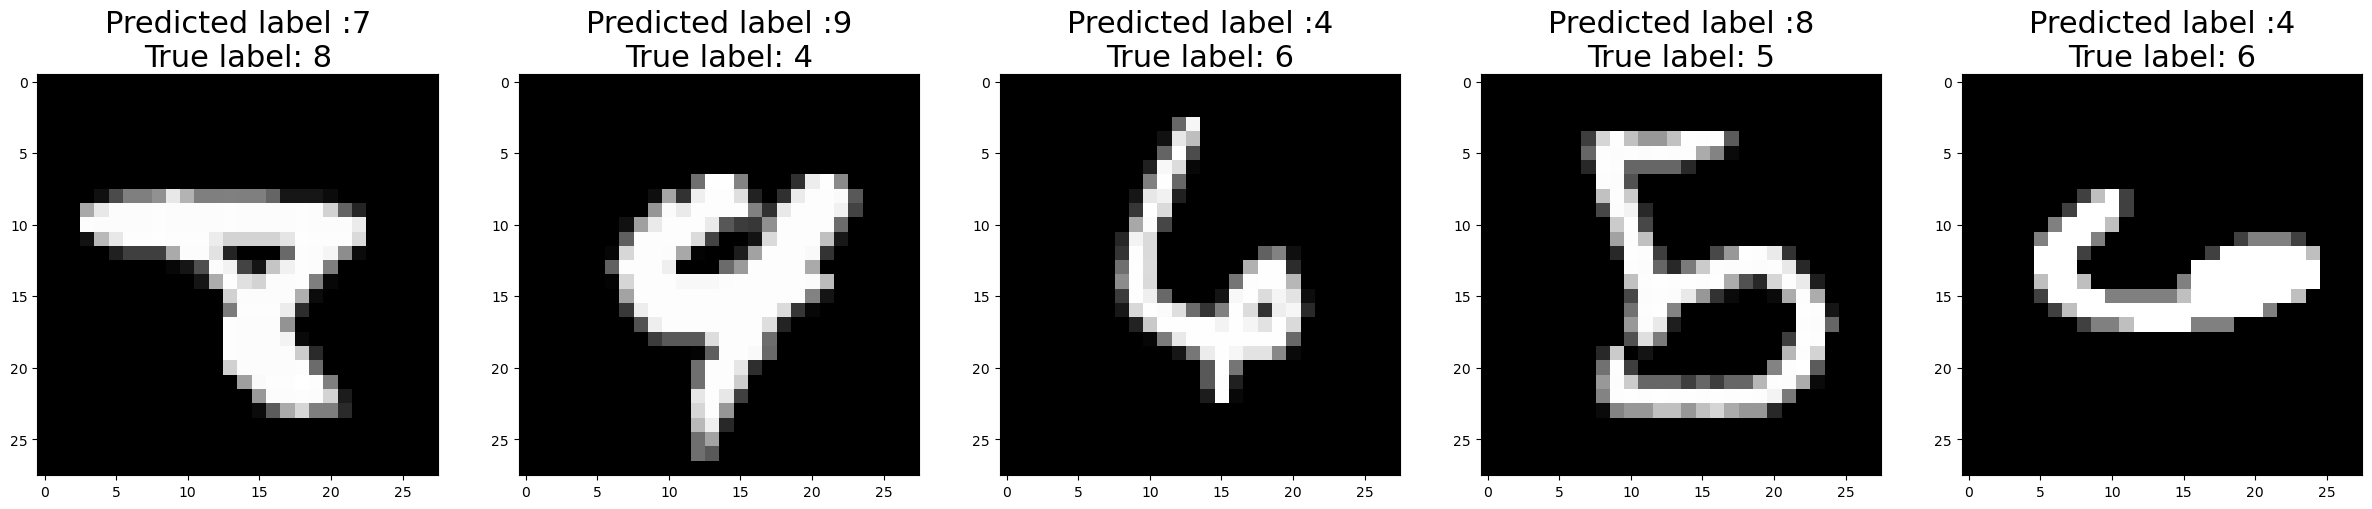

In [150]:
# Show Top Errors
num = len(top_idx_diff_errors)
f, ax = plt.subplots(1, num, figsize=(30,30))

for i in range(0, num):
  idx = top_idx_diff_errors[i]
  sample = x_test_errors[idx].reshape(28,28)
  y_t = y_true_errors[idx]
  y_p = y_pred_classes_errors[idx]
  ax[i].imshow(sample, cmap='gray')
  ax[i].set_title("Predicted label :{}\nTrue label: {}".format(y_p, y_t), fontsize=22)